In [1]:
# Python core Libraries
import sys
import os
import random as rnd
from os import listdir
from os.path import isfile, isdir, join
# Fundamental Libraries for Machine Learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
import glob   # In order to get images as matrices from directory
import pickle

# Scikit-Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Traditional Classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier  # Decision Tree Classifier
from sklearn.neighbors import KNeighborsClassifier # K Nearest Neighbor Classifier Algorithm
from sklearn.naive_bayes import GaussianNB # Naive Bayes Classifier
from sklearn.svm import SVC # Support Vector Machine Classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier 
# Classification Evaluation metrics and Visualization
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Evaluation metrics
from sklearn.metrics import classification_report  # Precision, recall, f1-score metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Classifier Confusion Matrix visualization
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# Tensorflow Libraries for Deep Neural Networks
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy

In [2]:
NUM_BATCHES = 32      # Number of batches for each epoch (common used batch size 32 is not suitable for out data)
NUM_EPOCH = 100        # How many epoch will be used for model training
IMG_SIZE = (90,90)    # Input Image size
INPUT_SIZE = (90, 90, 3) # RGB format Image
CONT_MARGIN = 1       # Contrastive Loss margin
K_FOLD_VALID = 10     # K for cross validation
RND_STATE = 24        # Randomness constant for robust outputs
SIM_THRESHOD = 0.5    # Similarity Threshold

# Dataset Directory
CAST_DATA_DIR        = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/'
CAST_TRAIN_OK_DIR    = CAST_DATA_DIR + 'train/ok_front'
CAST_TRAIN_DEF_DIR   = CAST_DATA_DIR + 'train/def_front'
CAST_TEST_OK_DIR     = CAST_DATA_DIR + 'test/ok_front'
CAST_TEST_DEF_DIR    = CAST_DATA_DIR + 'test/def_front'

In [3]:
# Each training and test example is assigned to one of the following labels:
labels = ["defect", "defect-free"]

In [4]:
def plot_seq_img_pairs(img_arr, label_arr, num_item, fig_size=[20,10], pair=2):
    for img_pair in range(pair):
        # Set figure size
        plt.figure(figsize=fig_size) 
        # Show each image from paired data
        for item in range(num_item):
            # rnd_img = random.randrange(0, len(img_arr)-1)
            display = plt.subplot(1, num_item, item+1)
            im = tf.keras.preprocessing.image.array_to_img(img_arr[item, img_pair], data_format=None, scale=True,dtype=None)
            plt.imshow(im, cmap="gray")
            act  = "" + str(labels[(int(label_arr[img_pair][item]))])
            
            plt.title(act)
            display.get_xaxis().set_visible(False)
            display.get_yaxis().set_visible(False)
        plt.show()

In [5]:
# Euclidean Distance: |X-Y| = sqrt(sum(square(x-y)))
def euclid_dis(vects):
    x, y = vects
    sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)   # If keepdims is False, the rank of the tensor is reduced by 1. If keepdims is True, the reduced dimension is retained with length 1.
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [6]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [7]:
def contrastive_loss(y_true, y_pred):
    y_true =tf.dtypes.cast(y_true, tf.float64)   # Casts a tensor to a new type.
    y_pred =tf.dtypes.cast(y_pred, tf.float64)
    margin = tf.dtypes.cast(CONT_MARGIN, tf.float64)
    
    square_pred = K.square(y_pred)    # ||F(A)-F(B)||^2
    margin      = K.square(margin)

    # Contrastive Loss
    # It is really similar to Cross entropy loss
    margin_square = K.maximum((margin - square_pred), 0)         # Acc: 0.9254 with 5 epochs tanh, 0.9535 for 20 epochs tanh, 0.9568 for 20 epochs relu, 0.9610 for 20 epochs relu last layer a.f. sigmoid

    # Loss function Le Cunn
    # margin_square = K.square(K.maximum((margin - y_pred), 0))  # Acc: 0.9677 with 5 epochs tanh, 0.9748 for 20 epochs tanh, 0.9856 for 20 epochs relu, 0.9586 for 20 epochs relu last layer a.f. sigmoid
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [8]:
def accuracy(y_true, y_pred):
    # Compute classification accuracy with a fixed threshold on distances.
    return K.mean(K.equal(y_true, K.cast(y_pred < SIM_THRESHOD, y_true.dtype)))

In [9]:
def compute_accuracy(y_true, y_pred):
    # Compute classification accuracy with a fixed threshold on distances
    pred = y_pred.ravel() < SIM_THRESHOD    # flats the content of the array and returns the array view (reference)
    return np.mean(pred == y_true)

In [10]:
def min_euclidean_dist_index(arr_list, const_arr):
    euclidean = lambda arr1: np.linalg.norm(arr1 - const_arr)
    return np.argmin(list(map(euclidean, arr_list)))
    #return np.min(list(map(euclidean, arr_list)))

In [11]:
def max_euclidean_dist_index(arr_list, const_arr):
    euclidean = lambda arr1: np.linalg.norm(arr1 - const_arr)
    return np.argmax(list(map(euclidean, arr_list)))
    #return np.max(list(map(euclidean, arr_list)))

In [12]:
def create_siamese_img_pairs(data_pair, dist_data=[], kind='random'):
    pairs = []
    labels_arr = []
    num_class = len(data_pair)

    n = min([len(data_pair[ix]) for ix in range(num_class)])-1
  
    for d in range(num_class):     
        for i in range(n):  
            inc = rnd.randrange(1, num_class)   # Select other classes
            dn = (d + inc) % num_class
            
            if kind == 'distance':
                euc_ix = min_euclidean_dist_index(dist_data[d], data_pair[d][i])
                pairs += [[data_pair[d][i], dist_data[d][euc_ix]]]
                euc_ix = max_euclidean_dist_index(dist_data[dn], data_pair[d][i])
                pairs += [[data_pair[d][i], dist_data[dn][euc_ix]]]
            else:
                pairs += [[data_pair[d][i], data_pair[d][i+1]]]
                pairs += [[data_pair[d][i], data_pair[dn][i]]]
            
            labels_arr += [1,0]
    return np.array(pairs), np.array(labels_arr)

In [13]:
os.listdir(CAST_TRAIN_OK_DIR)[0]   # File format is the .jpeg for this dataset

'cast_ok_0_3766.jpeg'

In [14]:
class VisionBasics():
    def __init__(self) -> None:
        self.files = []
        self.formats = ['jpg', 'png', 'jpeg']  # Add valid image formats here
        self._project_directory()
        pass

    def _project_directory(self):
        if (str(sys.platform) == "darwin") or (str(sys.platform) == "linux"):    # MacOS or Linux Environment
            current_dir = os.getcwd() + "/"
        else:   # Windows Environment
            current_dir = os.getcwd() + "\\"
        self.files = os.listdir(current_dir)

    def get_files(self):
        return self.files

    def print_files_of_project_directory(self):
        print(self.files)

    def save_ml_model(self, model, tag='Model'):
        pickle.dump(model, open(tag, 'wb'))

    def load_ml_model(self, directory):
        return pickle.load(open(directory, 'rb'))

    # Example of usage change_img_file_format method:
    # change_img_file_format.open(r'C:\Users\Ron\Desktop\Test\summer.png', )
    # TODO: Continue to write this method
    def change_img_file_format(self, img_dir, src_format, dest_format):
        cnv_rgx_frmt = lambda frmt: '\.' + frmt + '$' 
        rgx_formats = map(cnv_rgx_frmt, self.formats)

        if any([(re.search(format, img_dir)!=None) for format in rgx_formats]):
            if dest_format in self.formats:
                if dest_format in img_dir[-5:]:
                    print("UserWarning: This image file is already {0} format".format(dest_format))
                else:
                    img = Image.open(img_dir)
                    img.save()
            else:
                raise ValueError("Invalid image format, use '.png', '.jpeg', '.jpg' file formats")    
        else:
            raise ValueError("Invalid image format, use '.png', '.jpeg', '.jpg' file formats")

    ''' DEEP LEARNING METHODS FOR COMPUTER VISION '''
    # Load the specified file as a tf.image and preprocess it (see valid image formats)
    # See tf.keras.preprocessing.image_dataset_from_directory (https://keras.io/api/preprocessing/image/)
    def get_imgs_from_directory_as_numpy_array(self, dir, ext, size=None, scl=None, version=2):
        if ext in self.formats:
            rgx_for_img = dir + "/*." + ext
            img_list = glob.glob(rgx_for_img)

            # Scale image
            # scl_img = lambda img: ((img.astype('float32'))/255.0)

            if version < 0:
                # Function V0.1 (Use version 1 if any incompatibility on CUDA GPU version and the tf)
                # Cleanup called error on virtual machine
                if size is None:
                    img_arr = np.array([np.array(Image.open(img)) for img in img_list])
                else:
                    img_arr = np.array([np.array(Image.open(img).resize(size)) for img in img_list])

                img_arr = img_arr.astype('float32')
                if scl == '8bit': img_arr /= 255.0
                    
                return img_arr
            elif version == 1:
                def process_images(filename):
                    img = keras.preprocessing.image.load_img(filename, color_mode="rgb", target_size=size)
                    img_arr = keras.preprocessing.image.img_to_array(img)
                    img_arr = np.array(img_arr).astype('float32')  
                    if scl == '8bit': img_arr /= 255.0
                    return img_arr
                
                return np.array(list(map(process_images, img_list)))
                # https://keras.io/api/preprocessing/image/
                # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
            else:
                def process_images(filename):
                    image_string = tf.io.read_file(filename)
                    # Decode a JPEG-encoded image to a uint8 tensor
                    # image = tf.image.decode_image(image_string, channels=3)  
                    image = tf.image.decode_image(image_string, channels=0)    
                    # channels: An optional int. Defaults to 0. Number of color channels for the decoded image
                    # Detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert 
                    # the input bytes string into a Tensor of type dtype.
                    image = tf.image.convert_image_dtype(image, tf.float32)
                    image = image.numpy()
                    if size != None:
                        image = tf.image.resize(image, size)
                    if scl == '8bit':
                        image /= 255.0
                    return image

                return list(map(process_images, img_list))
        else:
            raise ValueError("Invalid image format, use '.png', '.jpeg', '.jpg' file formats")

    # This method prepares a data array as a keras input
    # Example of input_size parameter usage: (28,28,1) -> 28x28 pixels gray scale images, (28,28,3) 28x28 pixels RGB images
    # Example of np_array parameter usage: np_array.shape = (60000, 28, 28) OR (60000, 784)
    def prepare_imgs_as_keras_input(self, np_array, input_size):
        w, h, d = input_size
        return np_array.reshape(np_array.shape[0], w, h, d)

    # Visualize triplets from the batches
    def show_triplet_images(self, anchor, positive, negative, size=(10,10), row=3):
        def plot_img(ax, image):
            ax.imshow(image)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        fig = plt.figure(figsize=size)

        axs = fig.subplots(row, 3)
        for i in range(row):
            plot_img(axs[i, 0], anchor[i])
            plot_img(axs[i, 1], positive[i])
            plot_img(axs[i, 2], negative[i])

    ''' CONVENTIONAL CLASSIFICATION ALGORITHMS FOR COMPUTER VISION '''
    def get_misclassified_indexes(self, y_test, y_pred):
        missed = []
        missed = np.where(y_test[y_test != y_pred])
        return missed[0]

    # This methods prints all evaluation parameters for classification models
    def print_eval_parameters(self, model, y_test, y_pred, labels):
        print("====== " + type(model).__name__ +" model Evaluation metrics ======")
        print("Accuracy of model:      {:.3f}".format(accuracy_score(y_test, y_pred)))                    # Accuracy score: (tp + tn) / (tp + fp + tn + fn)
        print("Recall of model:        {:.3f}".format(recall_score(y_test, y_pred, average="micro")))     # Recall score: tp / (tp + fn)
        print("Precision of model:     {:.3f}".format(precision_score(y_test, y_pred, average="micro")))  # Precision score: tp / (tp + fp)
        print("F1 score of model:      {:.3f}".format(f1_score(y_test, y_pred, average="micro")))         # F1 score: 2 * (precision * recall) / (precision + recall)
        # print("Mean accuracy of the model (Score):  {:.3f}".format(model.score(X_train_valid_scl, y_train_valid)))  # Print model Mean Accuracy (score)
        print("Misclassification Number: ", (y_test != y_pred).sum())

        print("\n====== " + type(model).__name__ +" model Detailed Classification Report ======")
        # Print K Nearest Neighbor model's classification report for validation set
        # Report contains; Precision, recal and F1 score values for each label and 
        # model's accuracy, macro and weighted average
        print(classification_report(y_test, y_pred, target_names=labels))

    # This methods prints Grid Search Results for given search algorithm
    def print_grid_search_results(self, search):
        print("==== Grid Search Results ====")
        print("best_estimator: ", search.best_estimator_)
        print("best_params:    ", search.best_params_)
        print("best_score:      {:.3f}".format(search.best_score_))

    # This method plots Confusion matrix for classification models with given test dataset and prediction result array
    def show_confusion_matrix(self, y_test, y_pred, labels, w_h=(12, 7)):
        confMatrix = confusion_matrix(y_test, y_pred)
        dispConfMatrix = ConfusionMatrixDisplay(confMatrix, display_labels=labels)
        dispConfMatrix.plot()
        fig = plt.gcf()
        w, h = w_h
        fig.set_size_inches(w, h)

    # This method prints predicted and actual labels and shows actual image
    def show_prediction_result(self, x_test, y_pred, y_test, labels, n_img=None):
        # If n_img is not set, find random index between 0 and x_test length
        if n_img is None:
            n_img = rnd.randint(0, (len(x_test)- 1))
        print("====== Random Prediction Result ======")
        print("Predicted label: " + labels[y_pred[n_img]], end="")
        print("  -  Actual label: " + labels[y_test[n_img]])
        # If Predicted label and Actual label are not same there is a classification mismatch
        if labels[y_pred[n_img]] != labels[y_test[n_img]]:
            print("There is a classification mismatch here!")
        plt.title("The image of "+ labels[y_test[n_img]] +" from the Dataset")
        # plt.imshow(x_test[n_img], cmap=plt.cm.gray_r)
        plt.imshow(x_test[n_img])
        plt.show()

    def show_ROC_score(self, y_test, pos_prob, kind='fp_tp', plot=False, label='Custom Classifier'):
        if kind == 'fp_tp':   # False Positive-True Positive Curve
            auc_score = roc_auc_score(y_test, pos_prob)
            fp_rate, tp_rate, thresholds = roc_curve(y_test, pos_prob)
            plt_x, plt_y, lbl_x, lbl_y = fp_rate, tp_rate, "False Positive Rate (FP)", "True Positive Rate (TP)"
            # Generate a no skill prediction 
            noskill_probs = [0 for _ in range(len(y_test))]
            ns_auc_score = roc_auc_score(y_test, noskill_probs)
            noskill_fp_rate, noskill_tp_rate, noskill_thresholds = roc_curve(y_test, noskill_probs)

        elif kind == 'pre_rec':   # Precision-Recall Curve
            precision, recall, thresholds = precision_recall_curve(y_test, pos_prob)
            auc_score = auc(recall, precision)
            plt_x, plt_y, lbl_x, lbl_y = recall, precision, "Recall", "Precision"
        else:
            raise ValueError("Use 'fp_tp' or 'pre_rec' as kind parameter")

        print("AUC: ", auc_score)
        if kind == 'fp_tp':
            print("No-skill AUC: ", ns_auc_score)
        print("")

        if plot == True:
            plt.title("ROC Curve")
            plt.plot(plt_x, plt_y, marker='.', label=label)
            if kind == 'fp_tp':
                plt.plot(noskill_fp_rate, noskill_tp_rate, linestyle='--', label='No Skill Classifer')
            plt.xlabel(lbl_x)
            plt.ylabel(lbl_y)
            plt.legend()
            plt.show()

    def plot_randomly_img_predictions(self, img_arr, y_test, y_pred, labels, num_item=2, fig_size=[20,10]):
        plt.figure(figsize=fig_size) 
        for img in range(num_item):
            ix = rnd.randint(0, len(img_arr)-1)
            display = plt.subplot(1, num_item, img+1)

            plt.imshow(img_arr[ix], cmap="gray")
            act  = "Act: " + str(labels[(int(y_test[ix]))])
            pred = "Pred: " + str(labels[(int(y_pred[ix]))])

            plt.yticks([])
            plt.title(act)
            plt.ylabel(pred)

            display.get_xaxis().set_visible(False)
            #display.get_yaxis().set_visible(False)

        plt.show()

vision = VisionBasics()

In [15]:
x_train_ok = np.array(vision.get_imgs_from_directory_as_numpy_array(CAST_TRAIN_OK_DIR, ext="jpeg", size=IMG_SIZE, scl='8bit', version=1))
x_train_def = np.array(vision.get_imgs_from_directory_as_numpy_array(CAST_TRAIN_DEF_DIR, ext="jpeg", size=IMG_SIZE, scl='8bit', version=1))
x_test_ok = np.array(vision.get_imgs_from_directory_as_numpy_array(CAST_TEST_OK_DIR, ext="jpeg", size=IMG_SIZE, scl='8bit', version=1))
x_test_def = np.array(vision.get_imgs_from_directory_as_numpy_array(CAST_TEST_DEF_DIR, ext="jpeg", size=IMG_SIZE, scl='8bit', version=1))

In [16]:
print("x_train_ok.shape: ", x_train_ok.shape)
print("x_train_def.shape: ", x_train_def.shape)
print("x_test_ok.shape: ", x_test_ok.shape)
print("x_test_def.shape: ", x_test_def.shape)

x_train_ok.shape:  (2875, 90, 90, 3)
x_train_def.shape:  (3758, 90, 90, 3)
x_test_ok.shape:  (262, 90, 90, 3)
x_test_def.shape:  (453, 90, 90, 3)


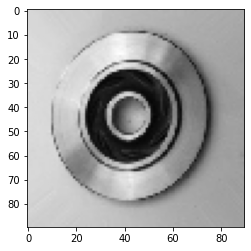

In [17]:
plt.imshow(x_test_ok[0])

In [18]:
x_train_class = [x_train_ok, x_train_def]
x_test_class = [x_test_ok, x_test_def]

In [19]:
tr_pairs, tr_y = create_siamese_img_pairs(x_train_class)
te_pairs, te_y = create_siamese_img_pairs(x_test_class)

In [20]:
# Building a sequential model
def create_siamese_net():
    # MODEL_1
    model = keras.Sequential(
    [
        keras.Input(shape = INPUT_SIZE),     # Give Shape of each image as input to the model 
        keras.layers.BatchNormalization(),   # Apply batch normalization
        keras.layers.Conv2D(4, (3,3), activation = 'relu', kernel_regularizer=l2(2e-4), input_shape=INPUT_SIZE),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_regularizer=l2(2e-4)),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_regularizer=l2(2e-4)),
        keras.layers.MaxPooling2D(pool_size = (2,2)),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(2, activation = 'softmax'),
    ]
    ) 

    model.summary()
    
    return model

In [21]:
# Siamese Network
siamese_network = create_siamese_net()

2023-01-08 14:15:09.025519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 14:15:09.035357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 14:15:09.036125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 14:15:09.037561: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 90, 90, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 88, 88, 4)         112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 44, 44, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 16)          0

node zero
2023-01-08 14:15:09.038614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 14:15:09.039295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 14:15:09.630175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 14:15:09.631035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 14:15:09.631721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

In [22]:
input_a = Input(shape=INPUT_SIZE)   # First input img
input_b = Input(shape=INPUT_SIZE)   # Second input img

encoded_a = siamese_network(input_a)
encoded_b = siamese_network(input_b)

In [23]:
distance = Lambda(euclid_dis, output_shape = eucl_dist_output_shape)([encoded_a, encoded_b])

model = Model([input_a, input_b], distance)   # distance is the output of the model

# Training process
opt = keras.optimizers.Adam(learning_rate=0.0001)   # (1e-5)
# opt = keras.optimizers.RMSprop(learning_rate=0.001)
# model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])

model_history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=NUM_BATCHES, epochs=NUM_EPOCH,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

2023-01-08 14:15:10.470825: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1117411200 exceeds 10% of free system memory.
2023-01-08 14:15:12.086347: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1117411200 exceeds 10% of free system memory.
2023-01-08 14:15:13.321640: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1117411200 exceeds 10% of free system memory.
2023-01-08 14:15:14.184181: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1117411200 exceeds 10% of free system memory.
2023-01-08 14:15:15.098876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-08 14:15:16.891666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


360/360 [==============================] - 7s 13ms/step - loss: 0.7877 - accuracy: 0.5138 - val_loss: 0.6408 - val_accuracy: 0.5362
Epoch 2/100
360/360 [==============================] - 4s 10ms/step - loss: 0.5097 - accuracy: 0.5745 - val_loss: 0.4259 - val_accuracy: 0.6208
Epoch 3/100
360/360 [==============================] - 4s 10ms/step - loss: 0.3533 - accuracy: 0.6900 - val_loss: 0.3154 - val_accuracy: 0.7511
Epoch 4/100
360/360 [==============================] - 4s 11ms/step - loss: 0.2658 - accuracy: 0.7707 - val_loss: 0.2408 - val_accuracy: 0.7956
Epoch 5/100
360/360 [==============================] - 4s 10ms/step - loss: 0.2040 - accuracy: 0.8236 - val_loss: 0.1992 - val_accuracy: 0.8407
Epoch 6/100
360/360 [==============================] - 4s 10ms/step - loss: 0.1647 - accuracy: 0.8574 - val_loss: 0.1621 - val_accuracy: 0.8739
Epoch 7/100
360/360 [==============================] - 4s 11ms/step - loss: 0.1367 - accuracy: 0.8799 - val_loss: 0.1452 - val_accuracy: 0.8881
Epoc

In [24]:
model_label = "siamese_model"
# model_dir = os.path.join(working_dir, save_id)
model.save(model_label)

2023-01-08 14:21:35.062050: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [25]:
# compute final accuracy on training and test sets
y_pred_train = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_train)
y_pred_test = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred_test)
 
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

2023-01-08 14:21:37.522718: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1117411200 exceeds 10% of free system memory.


* Accuracy on training set: 99.86%
* Accuracy on test set: 98.28%


<AxesSubplot:>

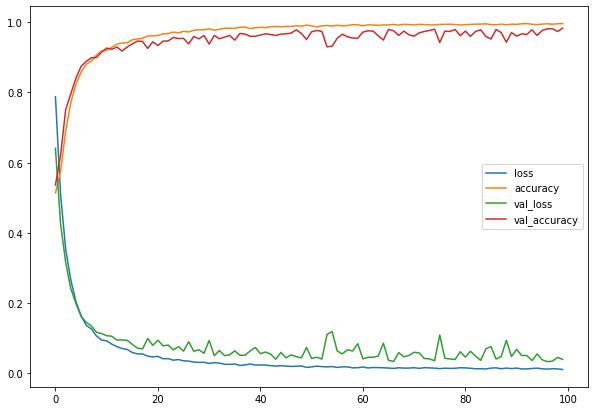

In [26]:
pd.DataFrame(model_history.history).plot(figsize=(10, 7))

In [27]:
test_loss, test_acc = model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y, verbose=2)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

33/33 - 0s - loss: 0.0394 - accuracy: 0.9830
Test Loss:  0.0393880195915699
Test Accuracy:  0.9829545617103577


In [28]:
# Set prediction results for evaluation metrics
reverse = lambda ix: 0 if ix > SIM_THRESHOD else 1

y_pred_abs = np.array([])            # Absolute value of prediction (If value greater than SIM_THRESHOD dissmilar, else similar)
y_pred_dis = np.copy(y_pred_test)  # Similarity metrics of the prediction. Rearrange predictions, if the distance greater than 1 set 1.

te_y_roc = np.array(list(map(reverse, te_y)))  # Reversed test labels for ROC curve (Distance of similar images are near to 0 but the label is 1)

for ix in range(len(y_pred_test)):
    if y_pred_test[ix] < SIM_THRESHOD:
        y_pred_abs = np.append(y_pred_abs, 1)
        if y_pred_test[ix] < 0.0:
            y_pred_dis[ix] = 0.0
    else:
        y_pred_abs = np.append(y_pred_abs, 0)
        if y_pred_test[ix] > 1.0:
            y_pred_dis[ix] = 1.0
                

y_pred_test[:5]

array([[3.0398394e-03],
       [1.9956770e+00],
       [3.3858204e-03],
       [1.9991574e+00],
       [1.3310751e-03]], dtype=float32)

In [29]:
vision.print_eval_parameters(model, te_y, y_pred_abs, labels)

====== Functional model Evaluation metrics ======
Accuracy of model:      0.983
Recall of model:        0.983
Precision of model:     0.983
F1 score of model:      0.983
Misclassification Number:  18

====== Functional model Detailed Classification Report ======
              precision    recall  f1-score   support

      defect       0.97      0.99      0.98       522
 defect-free       0.99      0.97      0.98       522

    accuracy                           0.98      1044
   macro avg       0.98      0.98      0.98      1044
weighted avg       0.98      0.98      0.98      1044



AUC:  0.9897828863346105
No-skill AUC:  0.5



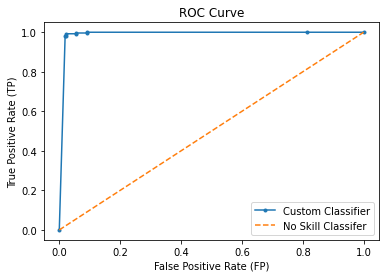

In [30]:
vision.show_ROC_score(te_y_roc, y_pred_dis, plot=True)

AUC:  0.989823425300253



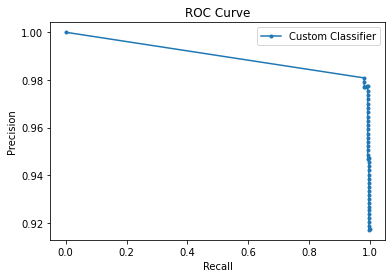

In [31]:
vision.show_ROC_score(te_y_roc, y_pred_dis, kind='pre_rec', plot=True)

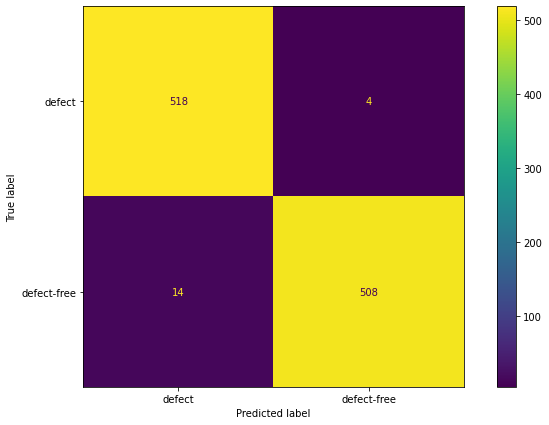

In [32]:
vision.show_confusion_matrix(te_y, y_pred_abs, labels)

In [33]:
# Create predict pairs array, add test labels and predicted labels respectively
predict_pairs = [te_y, y_pred_abs]

In [34]:
predict_pairs[0][1]

0

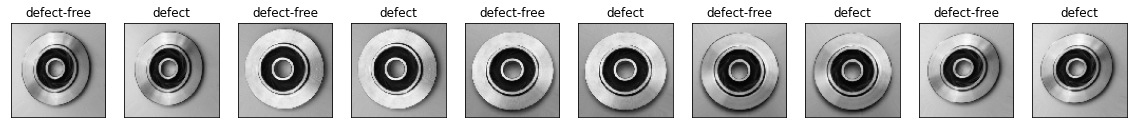

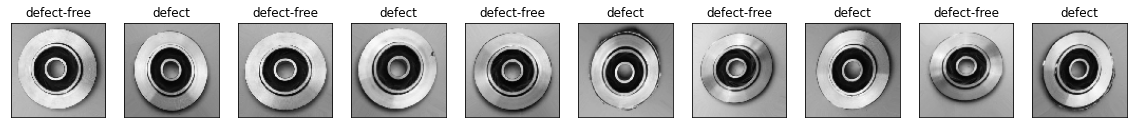

[0.00303984]  --- defect-free
[1.995677]  --- defect
[0.00338582]  --- defect-free
[1.9991574]  --- defect
[0.00133108]  --- defect-free
[1.9953926]  --- defect
[0.00257555]  --- defect-free
[1.9945297]  --- defect
[0.00208754]  --- defect-free
[1.9968412]  --- defect


In [35]:
number_of_items = 10

plot_seq_img_pairs(te_pairs, predict_pairs, number_of_items)
 
for i in range(number_of_items):
    if y_pred_test[i] > SIM_THRESHOD:
        print(y_pred_test[i], (" --- " + labels[0]))
    else:
        print(y_pred_test[i], (" --- " + labels[1]))